# Age discrepancy

In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import create_dataset_mri, cv_for_cde, create_dataset_eeg, cv
from cde.density_estimator import MixtureDensityNetwork
import numpy as np
import tensorflow as tf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.python.keras.activations import tanh
from sklearn.impute import SimpleImputer
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from scipy.stats import combine_pvalues
from patsy.contrasts import Treatment

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Behavioral data
behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
# Create dataset MRI
target = 'Age'
data = create_dataset_mri(SCORE = target)

test = data.loc[data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'Specific Learning Disorder with Impairment in Reading'])]
healthy = data.loc[data['DX_01'].isin(['No Diagnosis Given'])]

healthy.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
test.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)



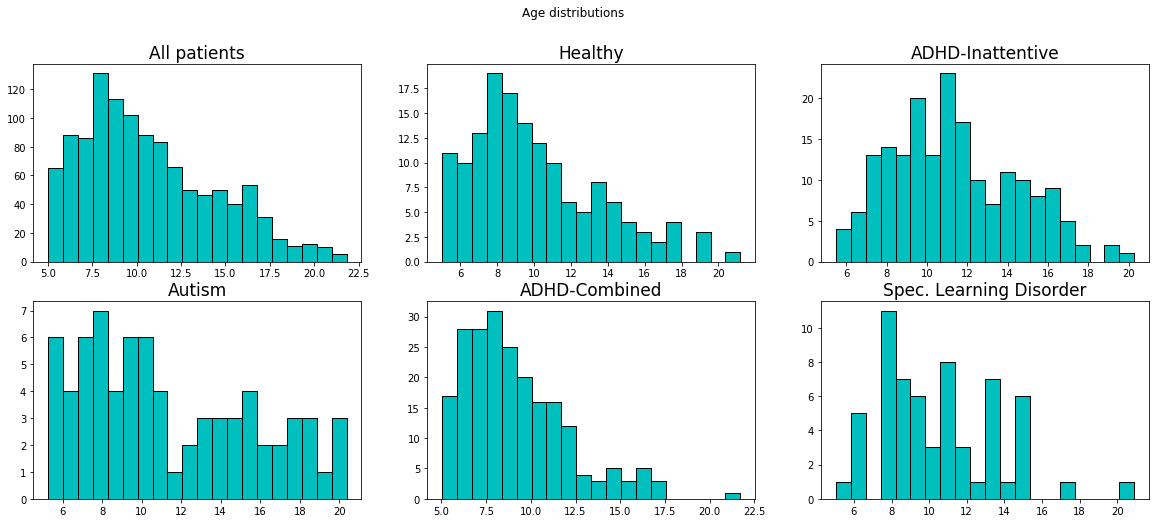

In [13]:
# Visualize distributions
autistics = data[data['DX_01']=='Autism Spectrum Disorder']
combined = data[data['DX_01']=='ADHD-Combined Type']
inattentive = data[data['DX_01']=='ADHD-Inattentive Type']
impaired = data[data['DX_01']=='Specific Learning Disorder with Impairment in Reading']
Healthy = data[data['DX_01']=='No Diagnosis Given']
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 8))
#plt.tick_params(labelsize=40)
fig.suptitle('Age distributions')
ax1.hist(np.array(data[['Age']]), bins=20, color='c', edgecolor='k')
ax1.set_title('All patients')
ax2.hist(np.array(Healthy[['Age']]), bins=20, color='c', edgecolor='k')
ax2.set_title('Healthy')
ax3.hist(np.array(inattentive[['Age']]), bins=20, color='c', edgecolor='k')
ax3.set_title('ADHD-Inattentive')
ax4.hist(np.array(autistics[['Age']]), bins=20, color='c', edgecolor='k')
ax4.set_title('Autism')
ax5.hist(np.array(combined[['Age']]), bins=20, color='c', edgecolor='k')
ax5.set_title('ADHD-Combined')
ax6.hist(np.array(impaired[['Age']]), bins=20, color='c', edgecolor='k')
ax6.set_title('Spec. Learning Disorder')
size = 17
ax1.title.set_size(size)
ax2.title.set_size(size)
ax3.title.set_size(size)
ax4.title.set_size(size)
ax5.title.set_size(size)
ax6.title.set_size(size)

In [5]:
# test
test = np.array(test)
ID_test_init = test[:,0]
X_test = test[:,2:]
y_test = test[:, 1]
y_test = y_test.reshape((-1,1))

# healthy
healthy = np.array(healthy)
y_healthy = healthy[:, 1]
X_healthy = np.concatenate((np.reshape(healthy[:,0],[-1,1]), healthy[:,2:]), axis = 1)
y_healthy = y_healthy.reshape((-1,1))


X_test_init = np.array(X_test, dtype=np.float64)
y_test_init = np.array(y_test, dtype=np.float64)


# split the healthy
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_healthy, y_healthy, test_size=0.5, random_state=3)
y_train_h = y_train_h.reshape((-1,1))
y_test_h = y_test_h.reshape((-1,1))
ID_train_h = X_train_h[:,0]
X_train_h = X_train_h[:,1:]
ID_test_h = X_test_h[:,0]
X_test_h = X_test_h[:,1:]
y_train_h = np.array(y_train_h, dtype=np.float64)
X_train_h = np.array(X_train_h, dtype=np.float64)
y_test_h = np.array(y_test_h, dtype=np.float64)
X_test_h = np.array(X_test_h, dtype=np.float64)
# Now add again
ID_test = np.concatenate((ID_test_init, ID_test_h))
y_test = np.concatenate((y_test_init, y_test_h))
X_test = np.concatenate((X_test_init, X_test_h))

ID_train = ID_train_h
y_train = y_train_h
X_train = X_train_h

In [6]:
# Set model parameters
ndim_x=X_train.shape[1]
ndim_y=y_train.shape[1]
# We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
n = X_train.shape[0]
d = X_train.shape[1]+y_train.shape[1]
h = n**(-1/(d+1))
# Define the model
model = MixtureDensityNetwork('MDNe', ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=300, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
# Fit
model.fit(X_train, y_train)
# Predict
y_pred = model.mean_(X_test)
y_pred = y_pred.reshape((-1,1))
y_pred.shape
print('Test MSE: {}'.format(mean_squared_error(y_pred, y_test)))

300/300 [100%] ██████████████████████████████ Elapsed: 3s | loss: 108.046
mean log-loss train: 1.4601
Test MSE: 6.136400200294877


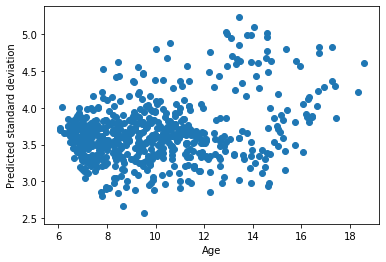

<Figure size 432x288 with 0 Axes>

In [8]:
plt.scatter( model.mean_(X_test), model.std_(X_test))
plt.xlabel('Age')
plt.ylabel('Predicted standard deviation')
plt.show()
plt.savefig('scatter.png', format="png")

In [7]:
# Define discrepancy
std = model.std_(X_test)
discrepancy = np.divide((y_test-y_pred), 1+std)
#discrepancy = y_test-y_pred
brain_age = y_pred

In [8]:
# Get dataframe for test observations with behavioral data + discrepancy
data = {'discrepancy':discrepancy[:,0], 'brain_age':brain_age[:,0]}
discrepancy_df = pd.DataFrame(data)
ID_df = pd.DataFrame({'EID':ID_test})
discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)
df = dataframe

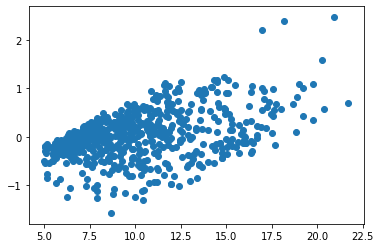

In [11]:
plt.scatter(dataframe['Age'], discrepancy)

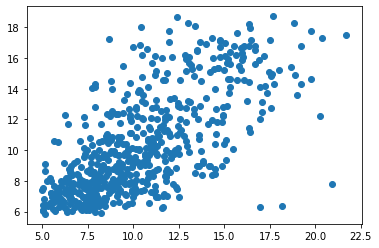

In [12]:
plt.scatter(dataframe['Age'], dataframe['brain_age'])

In [13]:
'''# Get the correlations
correlations = dataframe[dataframe.columns[1:]].corr()['discrepancy'][:]
# Inspect correlations
correlations[correlations > 0.3]'''

"# Get the correlations\ncorrelations = dataframe[dataframe.columns[1:]].corr()['discrepancy'][:]\n# Inspect correlations\ncorrelations[correlations > 0.3]"

In [14]:
# Frequencies of major disturb in behavioral dataset
dataframe['DX_01'].value_counts()

ADHD-Combined Type                                       217
ADHD-Inattentive Type                                    188
No Diagnosis Given                                        74
Autism Spectrum Disorder                                  73
Specific Learning Disorder with Impairment in Reading     61
Name: DX_01, dtype: int64

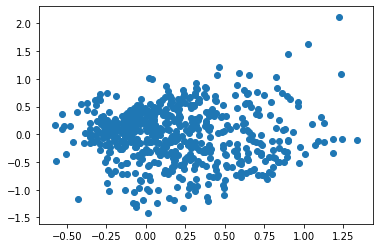

In [10]:
df = dataframe
model = ols("discrepancy ~ Age + C(DX_01, Treatment(reference='No Diagnosis Given'))", data=df).fit()


res = model.resid
fitted = model.fittedvalues
plt.scatter(fitted, res)
plt.show()

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     50.44
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           2.25e-43
Time:                        15:30:03   Log-Likelihood:                -303.96
No. Observations:                 584   AIC:                             619.9
Df Residuals:                     578   BIC:                             646.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================================================
                                                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                       -0.8239      0.080    -10.303      0.000      -0.981      -0.667
C(DX_01, Treatment(reference='No Diagnosis Given'))[T.ADHD-Combined Type]                                        0.1168      0.067      1.740      0.082      -0.015       0.249
C(DX_01, Treatment(reference='No Diagnosis Given'))[T.ADHD-Inattentive Type]                                     0.1761      0.068      2.574      0.010       0.042       0.310
C(DX_01, Treatment(reference='No Diagnosis Given'))[T.Autism Spectrum Disorder]                                  0.2098      0.078      2.689      0.007       0.057       0.363
C(DX_01, Treatment(reference='No Diagnosis Given'))[T.Specific Learning Disorder with Impairment in Reading]     0.1248      0.081      1.549      0.122      -0.033       0.283
Age                                                                                                              0.0754      0.005     14.286      0.000       0.065       0.086
==============================================================================
Omnibus:                        4.168   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                4.533
Skew:                          -0.104   Prob(JB):                        0.104
Kurtosis:                       3.379   Cond. No.                         91.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
pvals = [model.pvalues[1], model.pvalues[2], model.pvalues[3], model.pvalues[4]]
pvals

[0.0824734446899826,
 0.010304709263182044,
 0.007375524193191857,
 0.1218859379330173]

In [17]:
corrected = multipletests(pvals = pvals, alpha=0.05, method = 'fdr_bh')
corrected

(array([False,  True,  True, False]),
 array([0.10996459, 0.02060942, 0.02060942, 0.12188594]),
 0.012741455098566168,
 0.0125)

# Visualization

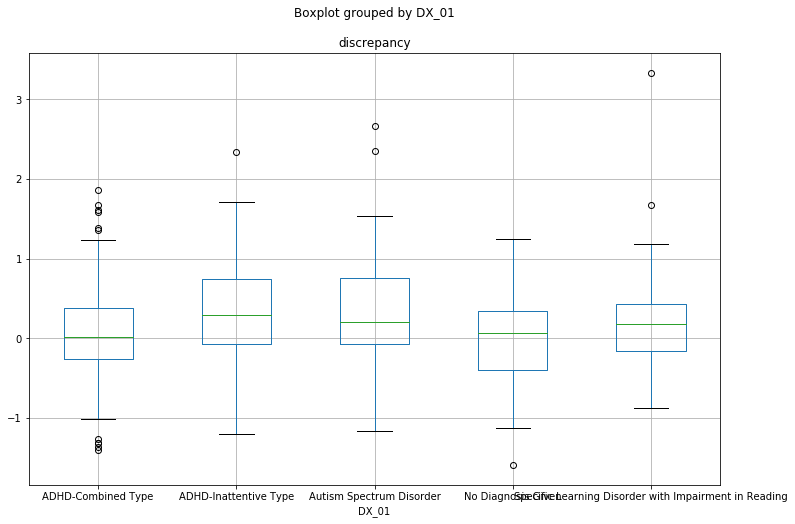

In [11]:
#Create a boxplot
df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))

In [4]:
def t_test(repetitions, balance = False, multiple_testing_correction = 'fdr_bh', aggreg = 'stouffer', test_size=0.5):
    # Behavioral data
    behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
    # Create dataset MRI
    target = 'Age'
    data = create_dataset_mri(SCORE = target)

    test = data.loc[data['DX_01'].isin(['Autism Spectrum Disorder', 'ADHD-Combined Type', 'ADHD-Inattentive Type', 'Specific Learning Disorder with Impairment in Reading'])]
    healthy = data.loc[data['DX_01'].isin(['No Diagnosis Given'])]
    
    healthy.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
    test.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)


    # test
    test = np.array(test)
    ID_test_init = test[:,0]
    X_test = test[:,2:]
    y_test = test[:, 1]
    y_test = y_test.reshape((-1,1))

    # healthy
    healthy = np.array(healthy)
    y_healthy = healthy[:, 1]
    X_healthy = np.concatenate((np.reshape(healthy[:,0],[-1,1]), healthy[:,2:]), axis = 1)
    y_healthy = y_healthy.reshape((-1,1))

    
    X_test_init = np.array(X_test, dtype=np.float64)
    y_test_init = np.array(y_test, dtype=np.float64)

    
    # things I want to compute
    t_adhd = []
    t_adhd_combined = []
    t_autism = [] 
    t_impaired = []
    
    for i in range(repetitions):
        # split the healthy
        X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_healthy, y_healthy, test_size=test_size, random_state=i)
        y_train_h = y_train_h.reshape((-1,1))
        y_test_h = y_test_h.reshape((-1,1))
        ID_train_h = X_train_h[:,0]
        X_train_h = X_train_h[:,1:]
        ID_test_h = X_test_h[:,0]
        X_test_h = X_test_h[:,1:]
        y_train_h = np.array(y_train_h, dtype=np.float64)
        X_train_h = np.array(X_train_h, dtype=np.float64)
        y_test_h = np.array(y_test_h, dtype=np.float64)
        X_test_h = np.array(X_test_h, dtype=np.float64)
        # Now add again
        ID_test = np.concatenate((ID_test_init, ID_test_h))
        y_test = np.concatenate((y_test_init, y_test_h))
        X_test = np.concatenate((X_test_init, X_test_h))

        ID_train = ID_train_h
        y_train = y_train_h
        X_train = X_train_h
    
        # Set model parameters
        ndim_x=X_train.shape[1]
        ndim_y=y_train.shape[1]
        # We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
        n = X_train.shape[0]
        d = X_train.shape[1]+y_train.shape[1]
        h = n**(-1/(d+1))
        model = MixtureDensityNetwork('a{}'.format(i), ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=100, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
        
        # Fit
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.mean_(X_test)
        y_pred = y_pred.reshape((-1,1))
        # Define discrepancy
        std = model.std_(X_test)
        discrepancy = np.divide((y_test-y_pred), 1+std)
        # Get dataframe for test observations with behavioral data + discrepancy
        data = {'discrepancy':discrepancy[:,0], 'brain_age':y_pred[:,0]}
        discrepancy_df = pd.DataFrame(data)
        ID_df = pd.DataFrame({'EID':ID_test})
        discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
        df = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
        
        if balance == True:
            # Correct for inbalance
            dataframe = df.sample(frac=1)
            df1 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type'])]
            df2 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Inattentive Type'])]
            df3 = dataframe.loc[dataframe['DX_01'].isin(['No Diagnosis Given'])]
            df4 = dataframe.loc[dataframe['DX_01'].isin(['Autism Spectrum Disorder'])]
            df5 = dataframe.loc[dataframe['DX_01'].isin(['Specific Learning Disorder with Impairment in Reading'])]
            size = min(df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0], df5.shape[0])
            df1 = df1.head(size)
            df2 = df2.head(size)
            df3 = df3.head(size)
            df4 = df4.head(size)
            df5 = df5.head(size)
            df = df1.append(df2, ignore_index=True)
            df = df.append(df3, ignore_index=True)
            df = df.append(df4, ignore_index=True)
            df = df.append(df5, ignore_index=True)
               
        
        from patsy.contrasts import Treatment
        model = ols("discrepancy ~ Age + C(DX_01, Treatment(reference='No Diagnosis Given'))", data=df).fit()
        p_vals = [model.pvalues[1], model.pvalues[2], model.pvalues[3], model.pvalues[4]]
        
        
        # Correct p-values for multiple-testing
        corrected = multipletests(pvals = p_vals, alpha=0.05, method = multiple_testing_correction)
        t_autism.append(corrected[1][2])
        t_adhd.append(corrected[1][1])
        t_adhd_combined.append(corrected[1][0])
        t_impaired.append(corrected[1][3])

        
    print('Mean p-val (inattentive vs healthy): {} \n Mean p-val (combined vs healthy): {} \n Mean p-val (autism vs healthy): {}, \n Mean p-val (impaired vs healthy): {}'.format(np.mean(t_adhd), np.mean(t_adhd_combined), np.mean(t_autism), np.mean(t_impaired)))
    print('Aggreg p-val (inattentive vs healthy): {} \n Aggreg p-val (combined vs healthy): {} \n Aggreg p-val (autism vs healthy): {}, \n Aggreg p-val (impaired vs healthy): {}'.format(combine_pvalues(t_adhd, aggreg)[1], combine_pvalues(t_adhd_combined, aggreg)[1], combine_pvalues(t_autism, aggreg)[1], combine_pvalues(t_impaired, aggreg)[1]))
    return([t_autism, t_adhd, t_adhd_combined, t_impaired])
    

In [6]:
(p1, p2, p3, p4) = t_test(5)

100/100 [100%] ██████████████████████████████ Elapsed: 10s | loss: 120.221
mean log-loss train: 1.6246
100/100 [100%] ██████████████████████████████ Elapsed: 5s | loss: 129.225
mean log-loss train: 1.7463
100/100 [100%] ██████████████████████████████ Elapsed: 5s | loss: 107.018
mean log-loss train: 1.4462
100/100 [100%] ██████████████████████████████ Elapsed: 11s | loss: 108.061
mean log-loss train: 1.4603
100/100 [100%] ██████████████████████████████ Elapsed: 13s | loss: 108.559
mean log-loss train: 1.4670
Mean p-val (inattentive vs healthy): 0.06884640523831252 
 Mean p-val (combined vs healthy): 0.12815900431229882 
 Mean p-val (autism vs healthy): 0.0400632502970633, 
 Mean p-val (impaired vs healthy): 0.09625381494187797
Aggreg p-val (inattentive vs healthy): 2.644541072556457e-07 
 Aggreg p-val (combined vs healthy): 0.0003369310078544306 
 Aggreg p-val (autism vs healthy): 2.073633462210473e-07, 
 Aggreg p-val (impaired vs healthy): 0.00012998370549451577


### Ranges of p-values over the 5 splits

In [7]:
p1  # autism


[0.008055942062509197,
 0.0005139895077861732,
 0.0018301977430889836,
 0.05030484394637649,
 0.13961127822555566]

In [8]:
p2  # inattentive

[0.001743114922499778,
 0.00036643356607944183,
 0.0018301977430889836,
 0.09119413218892512,
 0.24909814777096928]

In [9]:
p3 # combined

[0.02111109615899477,
 0.0072030363236986455,
 0.02169891223716028,
 0.2166735499532781,
 0.37410842688836243]

In [10]:
p4 # impaired

[0.019153559931430423,
 0.0072030363236986455,
 0.02169891223716028,
 0.13758002509042874,
 0.2956335411266718]